/tmp/ipykernel_1136059/3181529001.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
/tmp/ipykernel_1136059/3181529001.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
/tmp/ipykernel_1136059/3181529001.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
/tmp/ipykernel_1136059/3181529001.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, d

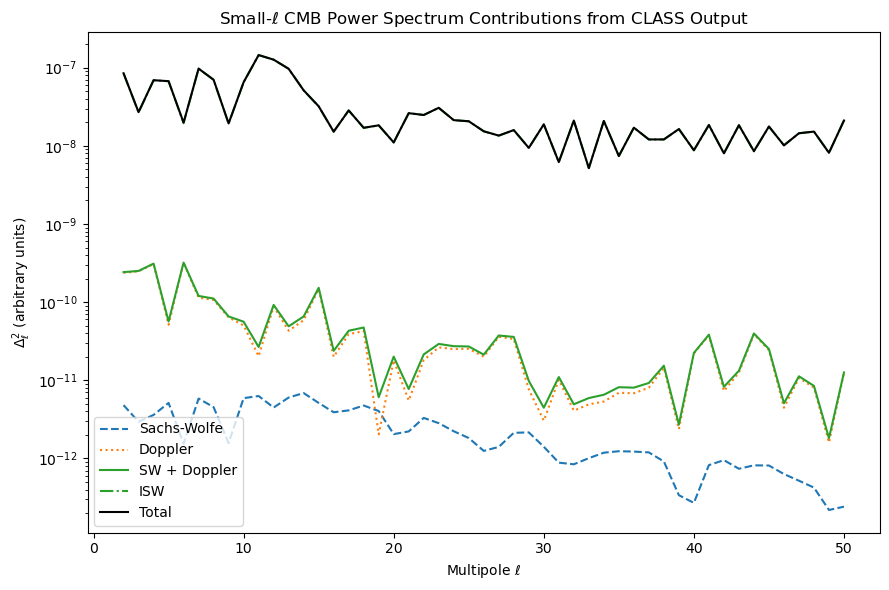

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import spherical_jn
import os
from glob import glob

# --- SETTINGS ---
data_folder = "./output"  # path to folder with CLASS outputs
file_pattern = "transfers_00_perturbations_k*_s.dat"
l_vals = np.arange(2, 51)
n_s = 0.965
A_s = 2.1e-9

def primordial_spectrum(k):
    return A_s * (k / 0.05)**(n_s - 1)

# --- FUNCTION TO PARSE EACH FILE ---
def process_single_file(file_path, k_val):
    df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
    df.columns = [
        "tau", "a", "delta_g", "theta_g", "shear_g",
        "pol0_g", "pol1_g", "pol2_g", "delta_b", "theta_b",
        "psi", "phi", "delta_ur", "theta_ur", "shear_ur",
        "delta_cdm", "theta_cdm"
    ]
    
    eta = df["tau"].values
    eta0 = eta[-1]
    delta_gamma = df["delta_g"].values
    psi = df["psi"].values
    phi = df["phi"].values
    theta_b = df["theta_b"].values

    SW_source = delta_gamma / 4 + psi
    Doppler_source = theta_b
    ISW_source = np.gradient(phi + psi, eta)

    def project_sw(source, eta, eta0, k_val):
        eta_star = eta[0]  # assuming first entry is LSS
        SW_at_eta_star = source[0]  # S_SW(η*)
        return np.array([SW_at_eta_star * spherical_jn(l, k_val * (eta0 - eta_star)) for l in l_vals])

    def project(source):
        return np.array([
            np.trapz(source * spherical_jn(l, k_val * (eta0 - eta)), eta)
            for l in l_vals
        ])

    def project_doppler(theta_b):
        return np.array([
        np.trapz(theta_b * (-k_val) * spherical_jn(l, k_val * (eta0 - eta), derivative=True), eta)
        for l in l_vals
    ])

    
    return project_sw(SW_source, eta, eta0, k_val), project_doppler(Doppler_source), project(ISW_source)

# --- MAIN SCRIPT ---
file_list = sorted(glob(os.path.join(data_folder, file_pattern)))
num_files = len(file_list)
k_values = np.logspace(np.log10(0.001), np.log10(0.0428), num_files)

SW_all, Doppler_all, ISW_all = [], [], []

for file_path, k_val in zip(file_list, k_values):
    sw, dop, isw = process_single_file(file_path, k_val)
    SW_all.append(sw)
    Doppler_all.append(dop)
    ISW_all.append(isw)

k_array = np.array(k_values)
logk_weights = np.gradient(np.log(k_array))
P_k = primordial_spectrum(k_array)

def integrate_component(components):
    stacked = np.vstack(components)
    integrand = (P_k[:, None] * stacked**2).T * logk_weights
    Cl = 4 * np.pi * np.sum(integrand, axis=1)
    return Cl

# --- Compute Δℓ² ---
Delta2_SW = integrate_component(SW_all)
Delta2_Doppler = integrate_component(Doppler_all)
Delta2_ISW = integrate_component(ISW_all)
Delta2_sw_dop = Delta2_SW + Delta2_Doppler
Delta2_total = Delta2_SW + Delta2_Doppler + Delta2_ISW

# --- Plot ---
plt.figure(figsize=(9, 6))
plt.plot(l_vals, Delta2_SW, label="Sachs-Wolfe", ls='--')
plt.plot(l_vals, Delta2_Doppler, label="Doppler", ls=':')
plt.plot(l_vals, Delta2_sw_dop, label="SW + Doppler", color='tab:green', ls='-')
plt.plot(l_vals, Delta2_ISW, label="ISW", ls='-.')
plt.plot(l_vals, Delta2_total, label="Total", color='black')
plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$\Delta_\ell^2$ (arbitrary units)")
plt.title(r"Small-$\ell$ CMB Power Spectrum Contributions from CLASS Output")
plt.legend()
plt.tight_layout()
plt.savefig("SW_DOP_ISW.png")
plt.show()


In [13]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

# 3.1) Load settings from your .ini
cosmo = Class()
cosmo.read("transfers.ini")
cosmo.compute()

# 3.2) Grab the raw transfer functions
data = cosmo.raw_transfer()
k_vals  = np.array(data["k"])
ell_vals= np.array(data["l"])
tt_names= data["tt"]        # e.g. ['t0','t1','t2','isw', ...]

# 3.3) Find the indices for SW, Doppler, ISW
i_sw   = tt_names.index("t0")
i_dop  = tt_names.index("t1")
i_isw  = tt_names.index("isw") if "isw" in tt_names else None

# 3.4) Extract the transfer arrays (shape: [k,ic,tt,ℓ])
T = np.array(data["transfer"])
SW     = T[:,0,i_sw,:]
Doppler= T[:,0,i_dop,:]
ISW    = T[:,0,i_isw,:] if i_isw is not None else np.zeros_like(SW)

# 3.5) Compute C_ℓ for each component
Pk    = np.array([cosmo.Ps(k) for k in k_vals])
dlnk  = np.gradient(np.log(k_vals))

def compute_Delta2(comp):
    integrand = (Pk[:,None] * comp**2) * (dlnk[:,None]/k_vals[:,None])
    Cl = 4*np.pi * integrand.sum(axis=0)
    return ell_vals*(ell_vals+1)/(2*np.pi) * Cl

Delta2_sw   = compute_Delta2(SW)
Delta2_dop  = compute_Delta2(Doppler)
Delta2_isw  = compute_Delta2(ISW)
Delta2_tot  = Delta2_sw + Delta2_dop + Delta2_isw

# 3.6) Plot
plt.figure(figsize=(8,5))
plt.plot(ell_vals, Delta2_sw,   "--", label="Sachs–Wolfe")
plt.plot(ell_vals, Delta2_dop,   ":",  label="Doppler")
plt.plot(ell_vals, Delta2_isw,   "-.", label="ISW")
plt.plot(ell_vals, Delta2_tot,   "-",  color="k", label="Total")
plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$\Delta_\ell^2$")
plt.legend()
plt.grid(which="both", ls="--")
plt.show()


AttributeError: 'classy.Class' object has no attribute 'read'

In [15]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

# 1) Define all your CLASS parameters in a dict
params = {
  "output":               "tCl,mTk",
  "l_max_scalars":        100,
  "k_per_decade_for_pk":  20,
  "write_transfer":       "yes",
  "transfer_k_per_decade":"20",
  "k_output_values":      "0.001,0.005,0.01",
  "P_k_ini type":         "analytic_Pk",
  "A_s":                  2.1e-9,
  "n_s":                  0.965,
  "h":                    0.6736,
  "omega_b":              0.02237,
  "omega_cdm":            0.12,
  "YHe":                  0.245
}

# 2) Initialize, set params, and compute
cosmo = Class()
cosmo.set(params)
cosmo.compute()

# 3) Grab the raw transfer functions
data    = cosmo.raw_transfer()
k_vals  = np.array(data["k"])
ell_vals= np.array(data["l"])
tt_names= data["tt"]   # e.g. ['t0','t1','t2','isw', ...]

# 4) Identify indices
i_sw   = tt_names.index("t0")             # Sachs–Wolfe
i_dop  = tt_names.index("t1")             # Doppler
i_isw  = tt_names.index("isw") if "isw" in tt_names else None

# 5) Extract the transfer arrays (shape [k,ic,tt,ℓ])
T = np.array(data["transfer"])
SW      = T[:,0,i_sw,:]
Doppler = T[:,0,i_dop,:]
ISW     = T[:,0,i_isw,:] if i_isw is not None else np.zeros_like(SW)

# 6) Compute Δℓ² for each component
Pk   = np.array([cosmo.Ps(k) for k in k_vals])
dlnk = np.gradient(np.log(k_vals))

def compute_Delta2(comp):
    integrand = (Pk[:,None] * comp**2) * (dlnk[:,None] / k_vals[:,None])
    Cl = 4*np.pi * integrand.sum(axis=0)
    return ell_vals*(ell_vals+1)/(2*np.pi) * Cl

Delta2_sw  = compute_Delta2(SW)
Delta2_dop = compute_Delta2(Doppler)
Delta2_isw = compute_Delta2(ISW)
Delta2_tot = Delta2_sw + Delta2_dop + Delta2_isw

# 7) Plot
plt.figure(figsize=(8,5))
plt.plot(ell_vals, Delta2_sw,   "--", label="Sachs–Wolfe")
plt.plot(ell_vals, Delta2_dop,   ":",  label="Doppler")
plt.plot(ell_vals, Delta2_isw,   "-.", label="ISW")
plt.plot(ell_vals, Delta2_tot,   "-",  color="k", label="Total")
plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$\Delta_\ell^2$")
plt.legend()
plt.grid(which="both", ls="--")
plt.show()


CosmoSevereError: 

Error in Class: Class did not read input parameter(s): write_transfer, transfer_k_per_decade


In [16]:
# Jupyter Notebook Cell: Compute & Plot SW, Doppler, ISW from CLASS perturbations

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn
import glob, os

# --- CONFIGURATION ---
# Path to folder containing all your CLASS perturbation files:
# e.g. transfers_00_perturbations_k0_s.dat, transfers_01_perturbations_k1_s.dat, ...
data_folder = "."  
pattern     = "transfers_*_perturbations_k*_s.dat"  

# Read all matching files
file_list = sorted(glob.glob(os.path.join(data_folder, pattern)))
if len(file_list) < 2:
    raise RuntimeError(f"Need at least 2 files to integrate over k, found {len(file_list)}")

# Extract k-values from filenames (assumes file ends in '_k{number}_s.dat')
k_vals = []
for fname in file_list:
    # simple parse: between '_k' and '_s'
    base = os.path.basename(fname)
    k_str = base.split("_k")[1].split("_")[0]
    k_vals.append(float(k_str))
k_vals = np.array(k_vals)

# Multipoles to compute
# Will be read from the first file's 'l' axis
# But most perturbation dumps don't include l: we project onto l=2..lmax manually
l_values = np.arange(2, 51)

# Hold source projections for each component
SW_proj    = []
Dop_proj   = []
ISW_proj   = []

# Loop over files
for k, filepath in zip(k_vals, file_list):
    # Load columns: 1: tau, 3: delta_g, 11: psi, 12: phi, 10: theta_b
    data = np.loadtxt(filepath)
    tau   = data[:,0]
    delta_gamma = data[:,2]
    psi   = data[:,10]
    phi   = data[:,11]
    theta_b     = data[:,9]

    # Conformal time today
    eta0 = tau.max()

    # Source terms
    SW_source    = delta_gamma/4.0 + psi
    Dop_source   = theta_b
    ISW_source   = np.gradient(phi + psi, tau)

    # Projection functions
    def project(source, use_derivative=False):
        arr = []
        for ell in l_values:
            x = k*(eta0 - tau)
            if use_derivative:
                # derivative of j_l w.r.t. eta: -k * j_l'(x)
                jl_prime = spherical_jn(ell, x, derivative=True)
                kernel  = -k * jl_prime
            else:
                kernel = spherical_jn(ell, k*(eta0 - tau))
            arr.append(np.trapz(source * kernel, tau))
        return np.array(arr)

    SW_proj.append(project(SW_source,  use_derivative=False))
    Dop_proj.append(project(Dop_source, use_derivative=True))
    ISW_proj.append(project(ISW_source, use_derivative=False))

# Convert lists to arrays: shape (n_k, n_l)
SW_arr  = np.vstack(SW_proj)
Dop_arr = np.vstack(Dop_proj)
ISW_arr = np.vstack(ISW_proj)

# Primordial spectrum (scale-invariant with tilt n_s=0.965)
n_s = 0.965
P_k = k_vals**(n_s - 4)

# Log-spacing weights for ∫ dln k
dlnk = np.gradient(np.log(k_vals))

# Compute C_ell component and Δ_l^2
def compute_Delta2(T_arr):
    # T_arr: shape (n_k, n_l)
    integrand = (P_k[:,None] * T_arr**2) * (dlnk[:,None] / k_vals[:,None])
    Cl = 4*np.pi * integrand.sum(axis=0)
    return l_values*(l_values+1)/(2*np.pi) * Cl

Delta2_SW  = compute_Delta2(SW_arr)
Delta2_Dop = compute_Delta2(Dop_arr)
Delta2_ISW = compute_Delta2(ISW_arr)
Delta2_TOT = Delta2_SW + Delta2_Dop + Delta2_ISW

# --- PLOT ---
plt.figure(figsize=(8,5))
plt.plot(l_values, Delta2_SW,   '--', label='Sachs–Wolfe')
plt.plot(l_values, Delta2_Dop,   ':',  label='Doppler')
plt.plot(l_values, Delta2_ISW,   '-.', label='ISW')
plt.plot(l_values, Delta2_TOT,   '-',  color='black', label='Total')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$\Delta_\ell^2$")
plt.title("CMB Temperature Power Spectrum Contributions")
plt.legend()
plt.grid(which="both", ls="--")
plt.tight_layout()
plt.show()


RuntimeError: Need at least 2 files to integrate over k, found 0

In [17]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

# 1) Build the exact same parameters as in your transfers.ini
params = {
    "output":                  "tCl,mTk",               # C_ℓ and mTk (transfer functions)
    "l_max_scalars":           100,
    "k_per_decade_for_pk":     20,
    "write transfer":          "yes",                   # note the space
    "transfer_sampling":       1,
    "transfer_k_output_values":"0.001,0.005,0.01,0.05,0.1",
    "P_k_ini type":            "analytic_Pk",
    "A_s":                     2.1e-9,
    "n_s":                     0.965,
    "h":                       0.6736,
    "omega_b":                 0.02237,
    "omega_cdm":               0.12,
    "YHe":                     0.245,
}

# 2) Run CLASS
cosmo = Class()
cosmo.set(params)
cosmo.compute()

# 3) Grab the raw transfer functions
data     = cosmo.raw_transfer()
k_vals   = np.array(data["k"])
ℓ_vals   = np.array(data["l"])
tt_names = data["tt"]      # e.g. ['t0','t1','t2','isw', ...]

# 4) Identify your SW, Doppler, ISW indices
i_sw  = tt_names.index("t0")            # Sachs–Wolfe
i_dop = tt_names.index("t1")            # Doppler
i_isw = tt_names.index("isw") if "isw" in tt_names else None

# 5) Extract transfer arrays: shape = (n_k, n_ic, n_tt, n_ℓ)
T       = np.array(data["transfer"])
SW      = T[:, 0, i_sw, :]
Doppler = T[:, 0, i_dop, :]
ISW     = T[:, 0, i_isw, :] if i_isw is not None else np.zeros_like(SW)

# 6) Do the ∫dk/k integral for each component
Pk   = np.array([cosmo.Ps(k) for k in k_vals])
dlnk = np.gradient(np.log(k_vals))

def Δ2(comp):
    integrand = (Pk[:,None] * comp**2) * (dlnk[:,None] / k_vals[:,None])
    Cℓ = 4*np.pi * integrand.sum(axis=0)
    return ℓ_vals*(ℓ_vals+1)/(2*np.pi) * Cℓ

Δ2_sw  = Δ2(SW)
Δ2_dop = Δ2(Doppler)
Δ2_isw = Δ2(ISW)
Δ2_tot = Δ2_sw + Δ2_dop + Δ2_isw

# 7) Plot Baumann‐style Fig. 7.7
plt.figure(figsize=(8,5))
plt.plot(ℓ_vals, Δ2_sw,  "--", label="SW")
plt.plot(ℓ_vals, Δ2_dop, ":",  label="Doppler")
plt.plot(ℓ_vals, Δ2_isw, "-.", label="ISW")
plt.plot(ℓ_vals, Δ2_tot, "-",  color="k", label="Total")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$\Delta_\ell^2\,[\mu{\rm K}^2]$")
plt.legend(); plt.grid(which="both", ls="--")
plt.tight_layout()
plt.show()


CosmoSevereError: 

Error in Class: Class did not read input parameter(s): write transfer, transfer_sampling, transfer_k_output_values
